# Assignment 1: Classification of Iris Using MLP

In [1]:
# [THIS IS READ-ONLY]
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# [THIS IS READ-ONLY]
#
# load the iris dataset as a dataframe.
#

df = pd.read_csv('my_data/iris.csv')

## Unit 1: constructing PyTorch datasets

In this unit, you are to implement `make_dataset`.

Hint:

- Learn how to use TensorDataset.
- You are to extract the features and target from the dataframe,
  and construct a TensorDataset object.
- Refer to https://pytorch.org/docs/stable/data.html

Note:

- Make sure the features are using `dtype=torch.float32`.
- Make sure the targets are using `dtype=torch.int64`.

In [3]:
# [THIS IS READ-ONLY]
import torch
from torch.utils.data import (
    DataLoader,
    TensorDataset,
    Dataset
)

In [4]:
# [YOUR WORK HERE]
# @workUnit

def make_dataset(df: pd.DataFrame) -> Dataset:
    X = torch.tensor(df.iloc[:, 0:4].values, dtype=torch.float32)
    y = torch.tensor(df.iloc[:, 4].values, dtype=torch.int64)
    return TensorDataset(X, y)

In [5]:
# [THIS IS READ-ONLY]
# @check
# @title: inspecting training dataset

train_dataset = make_dataset(df)
(x, y) = train_dataset[0]
print(f"First input {x}.  Its dtype must be {x.dtype}.")
print(f"First output {y}.  Its dtype must be {y.dtype}.")

First input tensor([6.1000, 2.8000, 4.7000, 1.2000]).  Its dtype must be torch.float32.
First output 1.  Its dtype must be torch.int64.


## Unit 2: constructing PyTorch dataloader

In this unit, you are to implement `make_dataloader` which converts
`Dataset` to `DataLoader` with specified `batch_size` and `shuffle` flag.

Refer to https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders

In [6]:
# [YOUR WORK HERE]
# @workUnit

def make_dataloader(dataset: Dataset, batch_size:int, shuffle:bool) -> DataLoader:
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [7]:
# [THIS IS READ-ONLY]
# @check
# @title: inspect training dataloader
train_dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=5)
first_batch = next(iter(train_dataloader))
first_batch

[tensor([[6.1000, 2.8000, 4.7000, 1.2000],
         [5.4000, 3.9000, 1.3000, 0.4000],
         [6.5000, 3.0000, 5.8000, 2.2000],
         [5.1000, 3.5000, 1.4000, 0.3000],
         [5.9000, 3.0000, 4.2000, 1.5000]]),
 tensor([1, 0, 2, 0, 1])]

## Unit 3: Linear classifier

In this unit, you are to implement a neural network module that performs
simple linear classification.  Namely,

$$ y_\mathrm{pred} = xW + b $$

Hint:

- Use the built-in `nn.Linear(...)` as a layer in your module.
- You must name the attribute in the `LinearClassifier` as `linear` for you to pass the checkpoint.

In [8]:
# [THIS IS READ-ONLY]
from torch import nn
from torchinfo import summary

In [9]:
# [YOUR WORK HERE]
# @workUnit
# initialize the `linear` attribute
# implement the forward(...) method

class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3)
        
    def forward(self, x):
        return self.linear(x)

In [10]:
# [THIS IS READ-ONLY]
# @check
# @title: architecture of linear classifier

m = LinearClassifier()
summary(m, input_size=(32,4))

Layer (type:depth-idx)                   Output Shape              Param #
LinearClassifier                         [32, 3]                   --
├─Linear: 1-1                            [32, 3]                   15
Total params: 15
Trainable params: 15
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Unit 4: Training loop

In this unit, you are given a function that performs the training loop.

You will use the provided training loop to train the linear classifier and inspect the accuracy.

In [11]:
# [THIS IS READ-ONLY]
from torch.optim import (Optimizer, Adam)
from torch.nn.functional import cross_entropy
from torchmetrics import Accuracy

In [12]:
# [THIS IS READ-ONLY]
def train(model: nn.Module, optimizer: Optimizer, dataloader: DataLoader, epochs: int):
    history = []
    accuracy = Accuracy(task='multiclass', num_classes=3)
    for epoch in range(epochs):
        for (x, target) in dataloader:
            pred = model(x)
            loss = cross_entropy(pred, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        metrics = {
            'epoch': epoch,
            'loss': loss.item(),
            'acc': accuracy(pred, target).item()
        }
        if epoch % (epochs // 10) == 0:
            print("{epoch}: loss={loss:.4f}, acc={acc:.2f}".format(**metrics))
        history.append(metrics)
    return pd.DataFrame(history)

In [13]:
# [YOUR WORK HERE]
# @workUnit

dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=32)
linearclassifier = LinearClassifier()
optimizer = Adam(linearclassifier.parameters())

history_linear = train(linearclassifier, optimizer, dataloader, 100)

0: loss=2.3190, acc=0.36
10: loss=1.6889, acc=0.36
20: loss=1.3166, acc=0.36
30: loss=1.1613, acc=0.32
40: loss=1.0765, acc=0.09
50: loss=0.9999, acc=0.09
60: loss=0.9287, acc=0.09
70: loss=0.8653, acc=0.45
80: loss=0.8101, acc=0.59
90: loss=0.7621, acc=0.68


In [14]:
# [THIS IS READ-ONLY]
# @check
# @title: ensure linear classifier performance

print("linear classifier acc > 50%?", history_linear.acc.iloc[-1] > 0.5)
print("linear classifier acc < 90%?", history_linear.acc.iloc[-1] < 0.9)

linear classifier acc > 50%? True
linear classifier acc < 90%? True


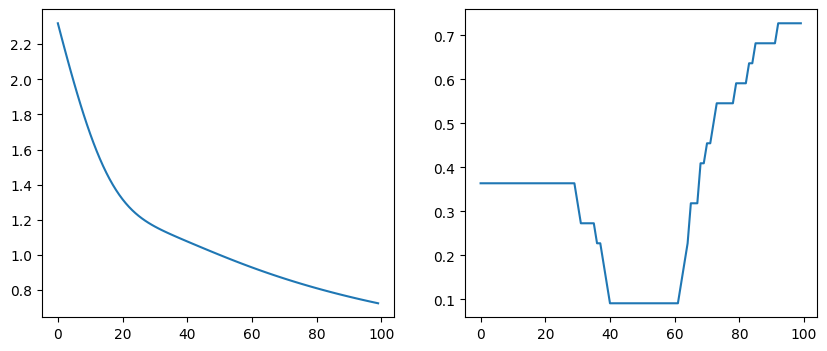

In [15]:
# [THIS IS READ-ONLY]
#
# Plotting the loss function and accuracy
#
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
history_linear.loss.plot.line(ax=axes[0])
history_linear.acc.plot.line(ax=axes[1]);

## Unit 5: MLP with hidden layer

In this section, you are to implement a multi-layer perceptron (MLP)
with a single hidden layer of 100 neurons.

Note: You must name the attributes as follows.

- `linear1`: the hidden layer with 100 neurons.
- `act1`: the ReLU activation function.
- `output`: the output layer that outputs the logits over the 3 categories.

Refer to: http://db.science.uoit.ca/csci4050u/2_fitting_2d/03_mlp.html

In [16]:
# [YOUR WORK HERE]
# @workUnit

class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4, 100)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(100, 3)
        
    def forward(self, x):
        x = self.act1(self.linear1(x))
        return self.output(x)

In [17]:
# [THIS IS READ-ONLY]
# @check
# @title: architecture of MLP classifier

m = MLPClassifier()
summary(m, input_size=(32,4))

Layer (type:depth-idx)                   Output Shape              Param #
MLPClassifier                            [32, 3]                   --
├─Linear: 1-1                            [32, 100]                 500
├─ReLU: 1-2                              [32, 100]                 --
├─Linear: 1-3                            [32, 3]                   303
Total params: 803
Trainable params: 803
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03

In [18]:
# [THIS IS READ-ONLY]
#
# training the MLP model
#
mlp = MLPClassifier()
optimizer = Adam(mlp.parameters())
dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=32)

history_mlp = train(mlp, optimizer, dataloader, 100)

0: loss=1.0690, acc=0.36
10: loss=0.5600, acc=0.82
20: loss=0.3893, acc=0.95
30: loss=0.3119, acc=0.95
40: loss=0.2577, acc=0.95
50: loss=0.2148, acc=0.95
60: loss=0.1804, acc=0.95
70: loss=0.1533, acc=0.95
80: loss=0.1321, acc=0.95
90: loss=0.1155, acc=0.95


In [19]:
# [THIS IS READ-ONLY]
# @check
# @title: ensure MLP performance

history_mlp.acc.iloc[-1] > 0.9

True

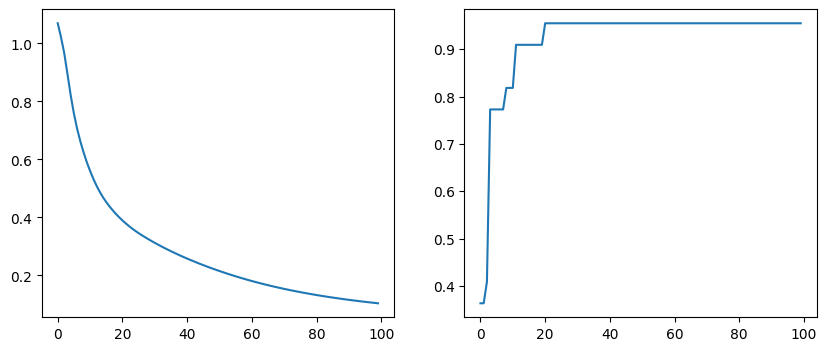

In [20]:
# [THIS IS READ-ONLY]
#
# Plotting the loss function and accuracy
#
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
history_mlp.loss.plot.line(ax=axes[0])
history_mlp.acc.plot.line(ax=axes[1]);

## Unit 6: Explaining MLP action

In this unit, we will explore ways to uncover how deep neural networks organize data by
generating 2D hidden features and visualize the generated features as a scatter plot.

You must create a `MLP2DClassifier` neural network consisting of the following layers:

- `linear1` is a linear layer with 100 neurons.
- `act1` is the ReLU activation function for the `linear1` layer.
- `linear2` is a linear layer that maps the 100 dimensional hidden feature to 2 dimensional feature.
- `output` is a linear layer that maps the 2D feature to 3D logits.

It is the output of `linear2` layer provides insight into how `x2 = act1(linear1(x))` works.

Your implementation of `MLP2DClassifier` will have an additional method
`hiddenFeature(x)` that will return the output of `linear2`.

In [21]:
# [YOUR WORK HERE]
# @workUnit

class MLP2DClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4, 100)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(100, 2)
        self.output = nn.Linear(2, 3)
        
    def forward(self, x):
        x = self.act1(self.linear1(x))
        x2 = self.linear2(x)
        return self.output(x2)
        
    def hiddenFeature(self, x):
        x = self.act1(self.linear1(x))
        return self.linear2(x)

In [22]:
# [THIS IS READ-ONLY]
# @check
# @title: MLP2DClassifier architecture

m = MLP2DClassifier()
summary(m, input_size=(32, 4))

Layer (type:depth-idx)                   Output Shape              Param #
MLP2DClassifier                          [32, 3]                   --
├─Linear: 1-1                            [32, 100]                 500
├─ReLU: 1-2                              [32, 100]                 --
├─Linear: 1-3                            [32, 2]                   202
├─Linear: 1-4                            [32, 3]                   9
Total params: 711
Trainable params: 711
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03

In [23]:
# [THIS IS READ-ONLY]
mlp2 = MLP2DClassifier()
optimizer = Adam(mlp2.parameters())
dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=32)

history_mlp2 = train(mlp2, optimizer, dataloader, 100)

0: loss=1.1333, acc=0.18
10: loss=0.8238, acc=0.59
20: loss=0.5657, acc=0.55
30: loss=0.4415, acc=0.77
40: loss=0.3736, acc=0.82
50: loss=0.3093, acc=0.95
60: loss=0.2411, acc=0.95
70: loss=0.1777, acc=0.95
80: loss=0.1329, acc=0.95
90: loss=0.1034, acc=0.95


In [24]:
# [THIS IS READ-ONLY]
# @check
# @title: ensure MLP2 performance

history_mlp2.acc.iloc[-1] > 0.9

True

In [25]:
# [THIS IS READ-ONLY]
#
# compute the hidden features for the first 100 training samples
#

(x, target) = train_dataset[0:100]
with torch.no_grad():
    x2 = mlp2.hiddenFeature(x)

In [26]:
# [THIS IS READ-ONLY]
# @check
# @title: get the hidden layout output

x2.shape

torch.Size([100, 2])

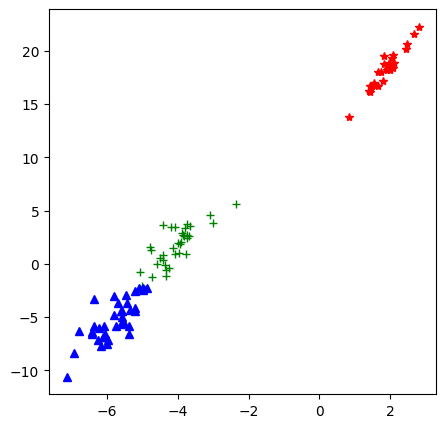

In [27]:
# [THIS IS READ-ONLY]
#
# Plot the three species using their hidden features
#

I0 = target == 0
I1 = target == 1
I2 = target == 2

plt.figure(figsize=(5,5))
plt.plot(x2[I0, 0], x2[I0, 1], '*', color='red');
plt.plot(x2[I1, 0], x2[I1, 1], '+', color='green');
plt.plot(x2[I2, 0], x2[I2, 1], '^', color='blue');